In [32]:
# General setup

# imports
import pandas as pd
import obspy
#import numpy as np
#from sys import exit
import os
import glob
#import shutil
import sys
LIBpath = os.path.join( os.getenv('HOME'),'src','kitchensinkGT', 'LIB')
sys.path.append(LIBpath)
from libseisGT import inventory2traceid, get_FDSN_inventory, \
    get_FDSN_Stream, clean_trace #, attach_station_coordinates_from_inventory, 
from libgeoGT import km2deg
from seisan_classes import filetime2wavpath, filetime2spath
#from metrics import eventStatistics
import numpy as np
from metrics import clean_trace, ampengfft
sys.path.append(os.path.join( os.getenv('HOME'),'src', 'icewebPy') )
import IceWeb  
from obspy.imaging.cm import obspy_sequential
from obspy.clients.fdsn import Client
from obspy.geodetics import locations2degrees, degrees2kilometers
SEISAN_TOP = os.getenv('SEISAN_TOP')
#CALDIR = os.path.join(SEISAN_TOP, 'CAL' )
def stream2wavfilename(st):
    min_stime, max_stime, min_etime, max_etime = Stream_min_starttime(st)
    isofmt = min_stime.isoformat()
    wavname = isofmt[0:10] + "-" + isofmt[11:13] + isofmt[14:16] + "-" + isofmt[17:19] + 'S.%s__%03d' % (SEISAN_DB, (len(st)+1))    
    return wavname

def makefolder(filepath):
    thisfolder = os.path.dirname(filepath)
    if not os.path.exists(thisfolder):
        print("mkdir ",thisfolder)
        os.makedirs(thisfolder)
        
def attach_station_coordinates_from_inventory(inventory, st):
    """ attach_station_coordinates_from_inventory """
    for tr in st:
        for netw in inventory.networks:
            for sta in netw.stations:
                if tr.stats.station == sta.code and netw.code == tr.stats.network:
                    for cha in sta.channels:
                        if tr.stats.location == cha.location_code:
                            tr.stats.coordinates = AttribDict({
                                'latitude':cha.latitude,
                                'longitude':cha.longitude,
                                'elevation':cha.elevation})
                            

In [33]:
# Setup for Hunga Tonga

#TOPDIR = '/home/seisan/MiamiLakes'
testmode = False

#SEISAN_DB = 'MLnew'
SEISAN_DB = 'Tonga'
#TOPDIR = os.path.join(os.getenv('HOME'), 'DATA', SEISAN_DB )
#if not os.path.exists(TOPDIR):
#    os.makedirs(TOPDIR)
csvmasterfile = 'TongaEruption.csv'    
    
# Estimated ource location
vlat = -(20 + 34/60 + 12 /3600) 
vlon = -(175 + 22/60 + 48/3600)

# Miami Lakes "Array" approx center - we draw a circle around this
LATITUDE = 25.911667
LONGITUDE = -80.325
NETWORK = "AM"
searchRadiusKm = 500
searchRadiusDeg = km2deg(searchRadiusKm)

# For downloading seismic data
fdsnClient = Client("RASPISHAKE")
PRE_TRIGGER_SECS = 0
POST_TRIGGER_SECS = 3600*3

# skip events before this
starttime = obspy.core.utcdatetime.UTCDateTime(2021,5,1,0,0,0)

#distdeg = locations2degrees(vlat, vlon, LATITUDE, LONGITUDE)
#distkm = degrees2kilometers(distdeg)
#traveltime = distkm * 1000 / 330 
#print(distdeg, distkm, traveltime)

In [34]:
# Download waveform and StationXML data for each event and store in Seisan WOR/CAL directory

df = pd.read_csv(csvmasterfile)
worfiles = []


''' ------------ Loop over Excel spreadsheet, download events, save as Miniseed --------------'''
for index, row in df.iterrows():
    if isinstance(row['time'], str):
        row['time'] = obspy.core.UTCDateTime(row['time'])
    if row['time'] < starttime.datetime:
        continue
    yyyymmddhhmm = row['time'].strftime('%Y%m%d%H%M')
    #startt = row['time'] - PRE_TRIGGER_SECS + traveltime
    #endt = row['time'] + POST_TRIGGER_SECS  + traveltime
    startt=obspy.UTCDateTime(2022,1,15,13,0,0)
    endt=obspy.UTCDateTime(2022,1,15,19,0,0)
    
    wavpath = filetime2wavpath(startt, mainclass='L', db=SEISAN_DB, seisan_data=SEISAN_TOP, fullpath=True, y2kfix=False, numchans=0)
    makefolder(wavpath)
    wavbase = os.path.basename(wavpath)
    
    worpath = os.path.join(SEISAN_TOP, 'WOR', wavbase)
    makefolder(worpath)
    
    sfilepath = filetime2spath(startt, mainclass='L', db=SEISAN_DB, seisan_data=SEISAN_TOP, fullpath=True)
    sfilebase = os.path.basename(sfilepath)
    makefolder(sfilepath)
    
    inv = None
    stationXmlFile = os.path.join(SEISAN_TOP, 'CAL', '%s.xml' % wavbase)   
    makefolder(stationXmlFile)
    if os.path.exists(stationXmlFile):
        inv = obspy.read_inventory(stationXmlFile)
    else:    
        try:
            inv = get_FDSN_inventory(fdsnClient, row['time'], stationXmlFile, NETWORK, LATITUDE, LONGITUDE, searchRadiusDeg, PRE_TRIGGER_SECS, POST_TRIGGER_SECS )
        except:
            pass
    if inv:
        print('Got inv for event at %s' % yyyymmddhhmm)
    else:
        print('No inv for event at %s' % yyyymmddhhmm)
        
        
    download_event = False
    
    # fuzzy match on WAVfile
    matchingWAVfiles = glob.glob(wavpath.replace('_000','*'))
    if len(matchingWAVfiles)==0:
        matchingWORfiles = glob.glob(worpath.replace('_000','*'))
        if len(matchingWORfiles)==0:
            # We need to get the waveform data
            download_event = True

    # if wavpath exists and sfilepath exists, event is already registered. nothing to do.
    
    # if wavpath exists and sfilepath does not, that's weird
    
    # if sfilepath exists, and wavpath does not, that's weird
    
    # if neither exists, we need to put the WAVfile into WOR directory for autoreg later
    if inv: # and download_event:
        
        # get list of unique trace ids
        trace_ids = inventory2traceid(inv)
        print('Will attempt to download waveforms for the following traceIDs:')
        print(trace_ids)
        
        # attempt to download event
        dummyfile = 'temporary.mseed'
        st = get_FDSN_Stream(fdsnClient, trace_ids, dummyfile, startt, endt )
        
        # update number of channels
        if st:
            print('Got %d channels of data for event at %s' % (len(st), yyyymmddhhmm))
            worpath2 = worpath.replace('_000', '_%03d' % len(st))
            st.write(worpath2, 'MSEED')
            worfiles.append(worpath2)
            os.remove(dummyfile)
        else:
            print('Got 0 channels of data for event at %s' % yyyymmddhhmm)
            os.remove(dummyfile)
    else:
        print('These files already match event at %s:' % yyyymmddhhmm)
        print(matchingWAVfiles)
        print(matchingWORfiles)
      

Trying to load inventory from 2022/01/15 04:30 to 2022/01/15 07:30
inventory saved to /Users/thompsong/seisan/CAL/2022-01-15-1300-00S.Tonga_000.xml
Got inv for event at 202201150430
Will attempt to download waveforms for the following traceIDs:
['AM.R976A.EHE', 'AM.R976A.EHN', 'AM.R976A.EHZ', 'AM.RA2B7.EHE', 'AM.RA2B7.EHN', 'AM.RA2B7.EHZ', 'AM.R17FC.HDF', 'AM.R17FC.EHZ', 'AM.R8CD2.EHZ', 'AM.R8CD2.ENE', 'AM.R8CD2.ENN', 'AM.R8CD2.ENZ', 'AM.R4FF5.EHE', 'AM.R4FF5.EHN', 'AM.R4FF5.EHZ', 'AM.R1E5E.EHE', 'AM.R1E5E.EHN', 'AM.R1E5E.EHZ', 'AM.RCC6E.HDF', 'AM.RCC6E.EHZ', 'AM.RADB2.EHE', 'AM.RADB2.EHN', 'AM.RADB2.EHZ', 'AM.RC57A.EHZ', 'AM.R7051.EHZ', 'AM.RC304.EHZ', 'AM.R2C45.HDF', 'AM.R2C45.EHZ', 'AM.R6324.EHE', 'AM.R6324.EHN', 'AM.R6324.EHZ', 'AM.R095E.HDF', 'AM.R095E.EHZ', 'AM.R19A5.EHZ', 'AM.R19A5.ENE', 'AM.R19A5.ENN', 'AM.R19A5.ENZ', 'AM.R0C15.EHZ']
AM.R976A.EHE
net=AM, station=R976A, chancode=EHE
AM.R976A.EHN
net=AM, station=R976A, chancode=EHN
AM.R976A.EHZ
net=AM, station=R976A, chancode=EHZ



icewebSpectrogram:
4 Trace(s) in Stream:
AM.R095E.00.HDF | 2022-01-15T14:09:21.504999Z - 2022-01-15T17:09:21.504999Z | 100.0 Hz, 1080001 samples
AM.R17FC.00.HDF | 2022-01-15T14:09:21.498999Z - 2022-01-15T17:09:21.498999Z | 100.0 Hz, 1080001 samples
AM.R2C45.00.HDF | 2022-01-15T14:09:21.498000Z - 2022-01-15T17:09:21.498000Z | 100.0 Hz, 1080001 samples
AM.RCC6E.00.HDF | 2022-01-15T14:09:21.496999Z - 2022-01-15T17:09:21.496999Z | 100.0 Hz, 1080001 samples
4 Trace(s) in Stream:
AM.R095E.00.HDF | 2022-01-15T14:09:21.504999Z - 2022-01-15T17:09:21.504999Z | 100.0 Hz, 1080001 samples
AM.R17FC.00.HDF | 2022-01-15T14:09:21.498999Z - 2022-01-15T17:09:21.498999Z | 100.0 Hz, 1080001 samples
AM.R2C45.00.HDF | 2022-01-15T14:09:21.498000Z - 2022-01-15T17:09:21.498000Z | 100.0 Hz, 1080001 samples
AM.RCC6E.00.HDF | 2022-01-15T14:09:21.496999Z - 2022-01-15T17:09:21.496999Z | 100.0 Hz, 1080001 samples


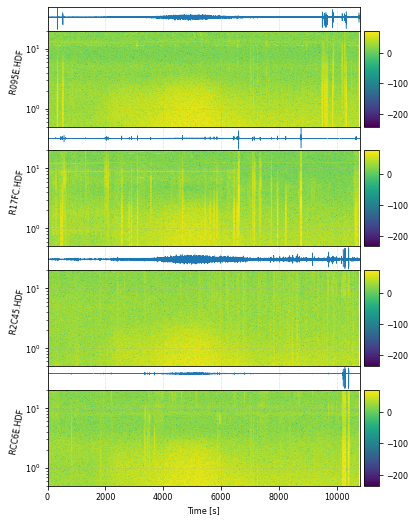

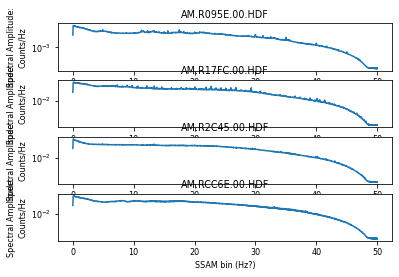

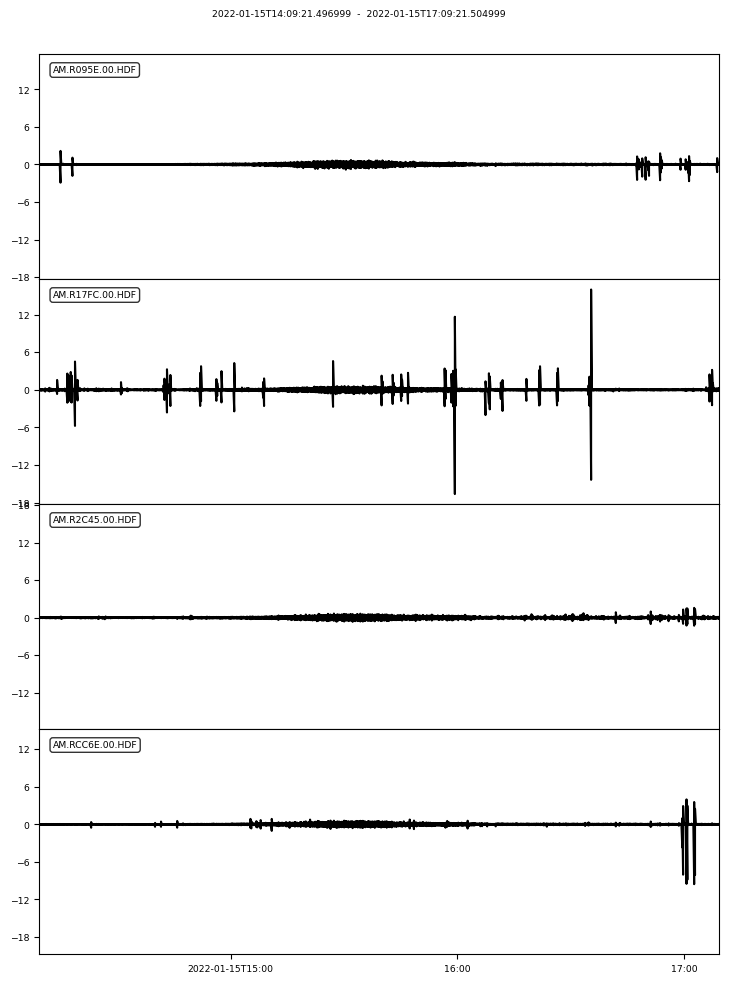

2022-01-15T14:09:21.504999Z 2022-01-15T17:08:56.856999Z
4 Trace(s) in Stream:
AM.R095E.00.HDF | 2022-01-15T14:09:21.504999Z - 2022-01-15T17:08:56.854999Z | 100.0 Hz, 1077536 samples
AM.R17FC.00.HDF | 2022-01-15T14:09:21.508999Z - 2022-01-15T17:08:56.858999Z | 100.0 Hz, 1077536 samples
AM.R2C45.00.HDF | 2022-01-15T14:09:21.508000Z - 2022-01-15T17:08:56.858000Z | 100.0 Hz, 1077536 samples
AM.RCC6E.00.HDF | 2022-01-15T14:09:21.506999Z - 2022-01-15T17:08:56.856999Z | 100.0 Hz, 1077536 samples


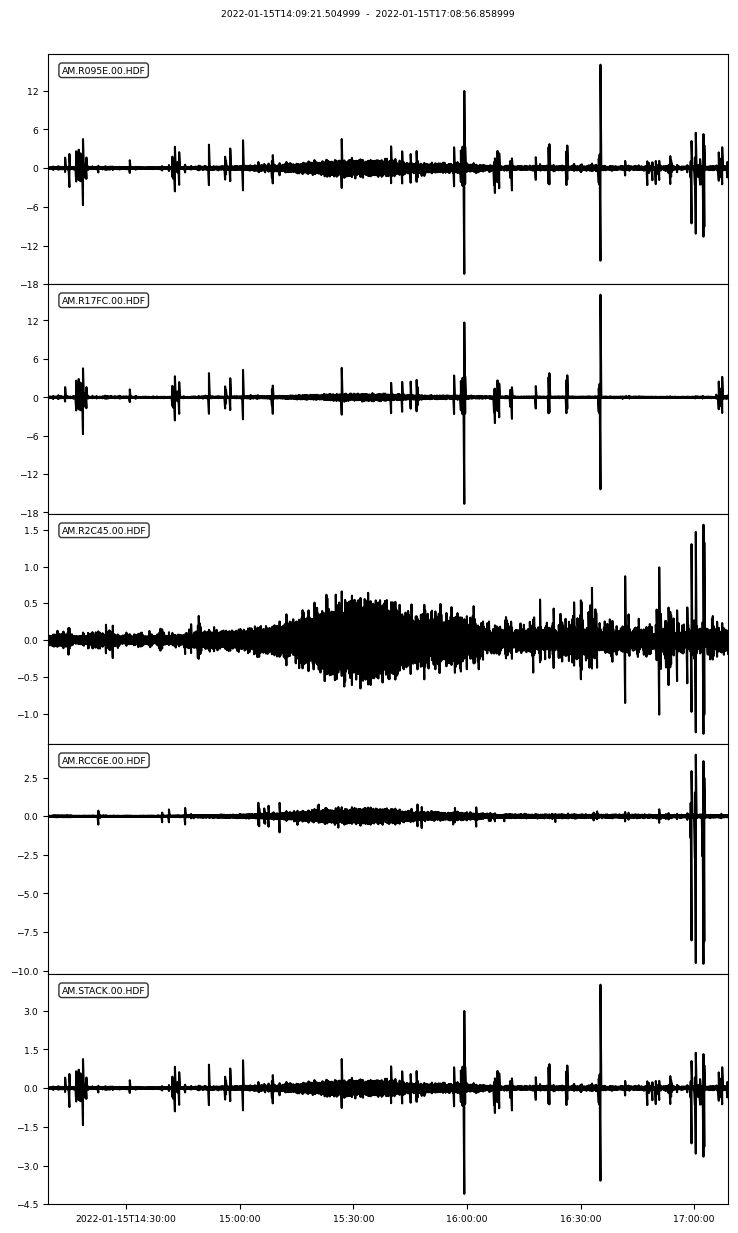

In [16]:
# Here we start with MiniSEED files and StationXML files


for worfile in worfiles:
    st = obspy.read(worfile)
    st = st.select(channel='HDF')
    
    # decimate to speed up
    #for tr in st:
    #    tr.decimate(10)
    #st.trim(starttime=obspy.UTCDateTime(2022,1,15,15,0,0), endtime=obspy.UTCDateTime(2022,1,15,16,0,0))

    wavbase = os.path.basename(worfile)
    stationXmlFilePattern = os.path.join(SEISAN_TOP, 'CAL', '%s.xml' % wavbase)[0:-6] 
    stationXmlFile = stationXmlFilePattern + '00.xml'
    if os.path.exists(stationXmlFile):
        inv = obspy.read_inventory(stationXmlFile)
        for tr in st:
            # SCAFFOLD not removing response here, because it wasn't working anyway
            clean_trace(tr, taperFraction=0.1, filterType="bandpass", freq=[0.05, 25.0], \
                        corners=3, zerophase=True, inv=inv)
            #qcTrace(tr)
            print('Units: %s' % tr.stats.units)
            physical_units = ['m', 'm/s', 'm/s2', 'Pa']
            if not tr.stats.units in physical_units:
                if tr.stats.channel == 'HDF':
                    print('Applying sensitivity of 56000 Counts / Pa')
                    tr.data = tr.data / 56000 # cal factor for Rboom
                    tr.stats.units = 'Pa'

    st.plot(equal_scale=True);

    # add coordinates
    attach_station_coordinates_from_inventory(inv, st)
    
    # compute distance
    for tr in st:
        tr.stats.distance = degrees2kilometers(locations2degrees(vlat, vlon, tr.stats.coordinates.latitude, tr.stats.coordinates.longitude))
    r = [tr.stats.distance for tr in st]
    minr = min(r)
    
    # compute travel time differences and sample delays
    v = 0.33
    for tr in st:
        tr.stats.tdiff = (tr.stats.distance - minr)/v
        tr.stats.sampledelay = np.round(tr.stats.tdiff/tr.stats.delta)    

    # align waveforms for stack, removing sample delays
    st_stack = st.copy()
    max_st = st_stack[0].stats.starttime-86400
    min_et = st_stack[0].stats.endtime
    for tr in st_stack:
        tr.stats.starttime = tr.stats.starttime - tr.stats.sampledelay * tr.stats.delta
        #print(tr.stats)
        if tr.stats.starttime > max_st:
            max_st = tr.stats.starttime    
        if tr.stats.endtime < min_et:
            min_et = tr.stats.endtime
    print(max_st, min_et)
    st_stack.trim(starttime=max_st, endtime=min_et)
    print(st_stack)

    # create the stack
    y = []
    for tr in st_stack:
        if len(y)>0:
            y += tr.data
        else:
            y = tr.data
    import matplotlib.pyplot as plt
    newtr = st_stack[0].copy()
    newtr.data = y / len(st_stack)
    newtr.stats.station='STACK'
    st_stack.append(newtr)
    st_stack.plot(equal_scale=False);

In [ ]:
# Spectrograms
for worfile in worfiles:
    st = obspy.read(worfile)
    st = st.select(channel='HDF')
    # add AEF metrics
    iwsobj = IceWeb.icewebSpectrogram(stream=st, secsPerFFT=100)
    iwsobj = iwsobj.precompute() # spectrograms data added
    iwsobj.plot(dbscale=True, cmap=obspy_sequential, log=True)
    print(iwsobj)
    print(iwsobj.stream)
    iwsobj.compute_amplitude_spectrum(compute_bandwidth=True) # adds tr.stats.spectrum
    iwsobj.plot_amplitude_spectrum()
    for tr in iwsobj.stream:
        ampengfft(tr) # add peaktime, peakamp, energy, frequency metrics
        #tr.stats.pop('spectrogramdata', None) # Remove spectrogramdata as it is large
    st = iwsobj.stream

    #iwsobj.plot(dbscale=False, cmap=obspy_sequential, log=True)

    #iwsobj.plot_amplitude_spectrum()

    #st.trim(starttime=obspy.UTCDateTime(2022,1,15,15,0,0), endtime=obspy.UTCDateTime(2022,1,15,16,0,0))
    #st.filter("bandpass", freqmin=0.05, freqmax=1.0, corners=3, zerophase=True)

In [30]:
for ai in range(len(st)):
    a = st_stack[ai]
    for bi in range(len(st)): 
        b = st_stack[bi]
        #samplediff = int(np.abs(a.stats.sampledelay - b.stats.sampledelay))
        #print(samplediff)
        cc = obspy.signal.cross_correlation.correlate_template(a, b)
        print(cc)
        shift, value = obspy.signal.cross_correlation.xcorr_max(cc)
        print(shift, value)
        index = np.argmax(cc)
        print(index, round(cc[index], 9) )


[ 1.]
0 0.9999999999999822
0 1.0
[ 0.58556989]
0 0.5855698904767103
0 0.58556989
[ 0.65700977]
0 0.6570097746425845
0 0.657009775
[ 0.65381578]
0 0.653815784826632
0 0.653815785
[ 0.58556989]
0 0.5855698904767314
0 0.58556989
[ 1.]
0 1.0000000000000173
0 1.0
[-0.00385638]
0 -0.003856379344447552
0 -0.003856379
[-0.00567425]
0 -0.005674249808990564
0 -0.00567425
[ 0.65700977]
0 0.6570097746426008
0 0.657009775
[-0.00385638]
0 -0.0038563793444475083
0 -0.003856379
[ 1.]
0 1.0000000000000047
0 1.0
[ 0.70243092]
0 0.7024309191272451
0 0.702430919
[ 0.65381578]
0 0.6538157848266515
0 0.653815785
[-0.00567425]
0 -0.0056742498089905336
0 -0.00567425
[ 0.70243092]
0 0.7024309191272503
0 0.702430919
[ 1.]
0 1.0000000000000122
0 1.0


In [ ]:
def medfilt(x, k):
    """Apply a length-k median filter to a 1D array x.
    Boundaries are extended by repeating endpoints.
    """
    assert k % 2 == 1, "Median filter length must be odd."
    assert x.ndim == 1, "Input must be one-dimensional."
    k2 = (k - 1) // 2
    y = np.zeros ((len (x), k), dtype=x.dtype)
    y[:,k2] = x
    for i in range (k2):
        j = k2 - i
        y[j:,i] = x[:-j]
        y[:j,i] = x[0]
        y[:-j,-(i+1)] = x[j:]
        y[-j:,-(i+1)] = x[-1]
    return np.median(y, axis=1)

st_stack.detrend()
for tr in st_stack:
    tr.data = medfilt(np.abs(tr.data), 1001)
    
st_stack.plot()

In [ ]:
st_zoom = stR.copy()
st_zoom.select(channel='HDF').trim(starttime=obspy.UTCDateTime(2022,1,15,15,1,0), endtime=obspy.UTCDateTime(2022,1,15,15,1,30))
st_zoom.select(channel='HDF').plot()


In [ ]:
st_env = st_stack.copy()

for tr in st_env:

    # Envelope of filtered data
    tr.data = obspy.signal.filter.envelope(tr.data)
    
st_env.plot();



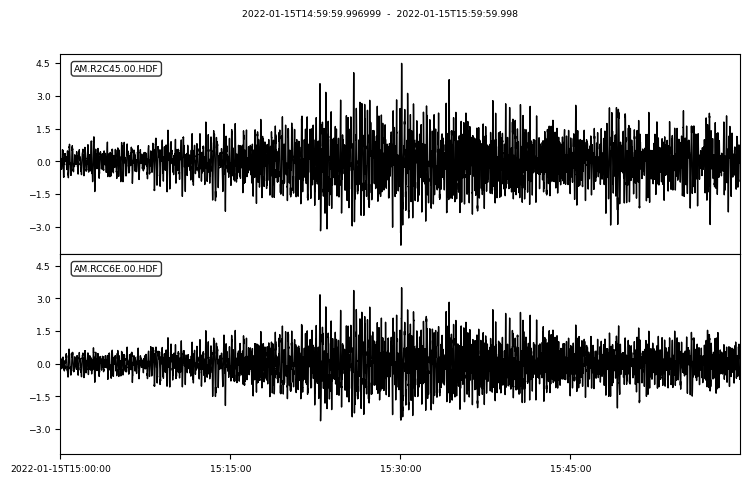

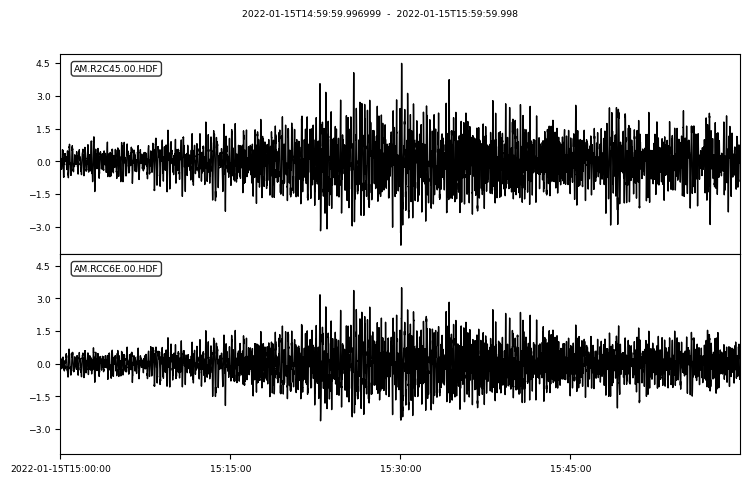

In [15]:
st_same = st[2:4].copy()
st_same.trim(starttime=obspy.UTCDateTime(2022,1,15,15,0,0), endtime=obspy.UTCDateTime(2022,1,15,16,0,0))
st_same.plot()

In [ ]:
stinfra.spectrogram()

In [ ]:
inv.plot('local');

In [ ]:
invinfra = inv.select(channel='HDF')
invinfra.plot('local')

In [ ]:
stas = invinfra.networks[0].stations
for sta in stas:
    print(sta)
    print(sta.channels[0])

In [ ]:
#stR.plot()
#stR.filter("bandpass", freqmin=0.05, freqmax=1.0, corners=3, zerophase=True)
stR.trim(starttime=obspy.UTCDateTime(2022,1,15,15,0,0), endtime=obspy.UTCDateTime(2022,1,15,16,0,0))
stR.plot(equal_scale=False)


In [ ]:
stC = removeInstrumentResponse(stR, preFilter = (0.01, 0.02, 30.0, 45.0), outputType = "VEL")